<a href="https://colab.research.google.com/github/johnamose/Lung_Sound_Analysis/blob/main/Event_Detection_Silero_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/SPRSound/SPRSound-main'

Mounted at /content/drive
/content/drive/My Drive/SPRSound/SPRSound-main


In [ ]:
pip install torch soundfile numpy

In [ ]:
import torch
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad', force_reload=True)
get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks = utils

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


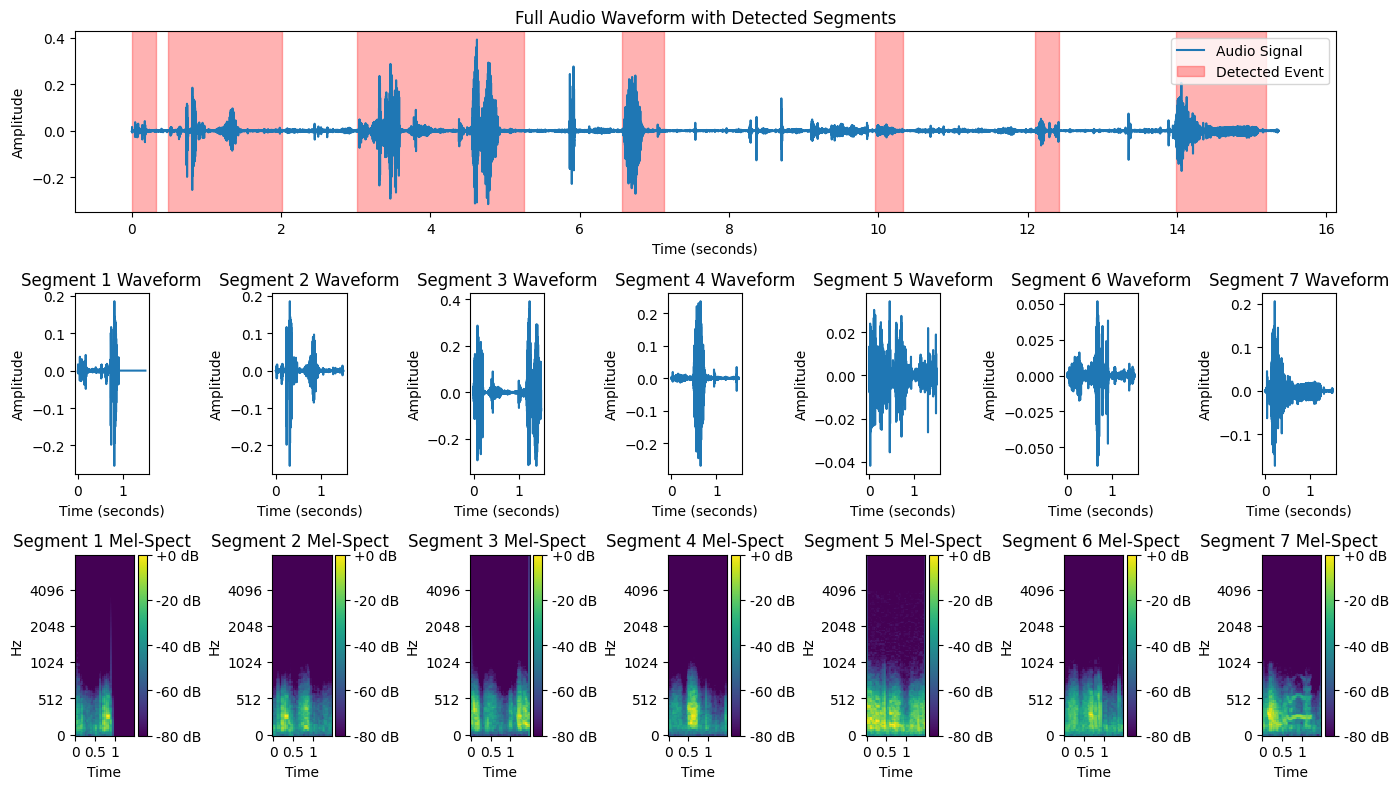

In [ ]:
import torch
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Load the Silero VAD model
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad', force_reload=True)
(get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils

def preprocess_audio(file_path, target_sr=16000):
    """
    Load and preprocess the lung sound audio file.
    """
    audio, sr = sf.read(file_path)
    if sr != target_sr:
        from scipy.signal import resample
        audio = resample(audio, int(len(audio) * target_sr / sr))
    return audio, target_sr

def detect_events(audio, model, sampling_rate=16000, threshold=0.5):
    """
    Detect events in lung sound audio using Silero VAD.
    """
    audio_tensor = torch.from_numpy(audio).float()
    if len(audio.shape) > 1:  # If stereo, convert to mono
        audio_tensor = torch.mean(audio_tensor, axis=1)
    timestamps = get_speech_timestamps(audio_tensor, model, sampling_rate=sampling_rate, threshold=threshold)
    return timestamps

def extract_centered_segment(audio, center, segment_length):
    """
    Extract a centered segment of fixed length around the midpoint of an event.
    """
    half_length = segment_length // 2
    start = max(center - half_length, 0)
    end = min(center + half_length, len(audio))
    segment = np.zeros(segment_length)
    segment[:end - start] = audio[start:end]
    return segment

def plot_full_waveform_with_segments(audio, sr, timestamps, segment_duration, segment_length):
    """
    Plot the full audio waveform with detected segments marked and their individual segments plotted.
    """
    time_axis = np.linspace(0, len(audio) / sr, len(audio))
    plt.figure(figsize=(14, 8))

    # Plot full audio waveform
    plt.subplot(3, 1, 1)
    plt.plot(time_axis, audio, label="Audio Signal")
    for i, ts in enumerate(timestamps):
        start, end = ts['start'] / sr, ts['end'] / sr
        plt.axvspan(start, end, color='red', alpha=0.3, label='Detected Event' if i == 0 else None)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Full Audio Waveform with Detected Segments')
    plt.legend(loc='upper right')
    plt.tight_layout()

    # Plot segments with their waveforms
    for i, ts in enumerate(timestamps):
        center = (ts['start'] + ts['end']) // 2
        segment = extract_centered_segment(audio, center, segment_length)
        time_axis_segment = np.linspace(0, segment_duration, segment_length)

        plt.subplot(3, len(timestamps), len(timestamps) + i + 1)
        plt.plot(time_axis_segment, segment)
        plt.title(f"Segment {i + 1} Waveform")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")

        # Plot Mel spectrogram of the segment
        plt.subplot(3, len(timestamps), len(timestamps) + len(timestamps) + i + 1)
        mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Segment {i + 1} Mel-Spect ")

    plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots
    plt.tight_layout()  # Further refine layout
    plt.show()

# Main function
if __name__ == "__main__":
    file_path = "/content/drive/My Drive/SPRSound/SPRSound-main/train_wav/41267024_0.3_0_p1_2766.wav"  # Replace with your lung sound file
    threshold = 0.01  # Adjust threshold as needed for lung sound sensitivity
    segment_duration = 1.5  # Desired duration of each segment in seconds

    # Preprocess and detect events
    audio, sr = preprocess_audio(file_path)
    timestamps = detect_events(audio, model, sampling_rate=sr, threshold=threshold)

    # Calculate segment length
    segment_length = int(segment_duration * sr)  # Convert duration to samples

    # Plot full waveform with segments and Mel spectrograms
    plot_full_waveform_with_segments(audio, sr, timestamps, segment_duration, segment_length)
